In [171]:
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np
import pandas as pd

# the top 20 girl names from 1970
top_names = [
    'Jennifer', 'Lisa', 'Kimberly', 'Michelle', 'Amy', 'Angela', 'Melissa',
    'Tammy', 'Mary', 'Tracy', 'Julie', 'Karen', 'Laura', 'Christine', 'Susan',
    'Dawn', 'Stephanie', 'Elizabeth', 'Heather', 'Kelly'
]
# the X-axis data from the extracted responses are years from 1960 - 2021 (62 rows)

In [172]:
cached_retrieval = {}
def retrieve_data_for_name_start_year(name, start_year):
    if name in cached_retrieval:
        return cached_retrieval[name]
    
    url = 'https://www.ssa.gov/cgi-bin/babyname.cgi'
    data = {'name': name, 'start': start_year, 'sex': 'F'}
    
    resp = requests.post(url, data=data)
    cached_retrieval[name] = BeautifulSoup(resp.content)
    return cached_retrieval[name]

In [173]:
def extract_data_for_name(name):
    static_start = 1960
    year_ix = 0
    rank_ix = 1
    
    soup = retrieve_data_for_name_start_year(name, static_start)
    main_table = soup.find_all('table')[1]
    data_rows = [r for r in main_table.select('p > table')[1:] if len(list(r.children)) == 1]
    print(f'-----{len(data_rows)} rows of name data for {name}----')

    rank_vector = []
    year_vector = []
    for r in data_rows:
        cols = r.find_all('td')
        try:
            rank_vector.append(int(cols[rank_ix].get_text()))
            year_vector.append(int(cols[year_ix].get_text()))
        except IndexError:
            print(f'ERROR WITH ROW {r}, data is {r.find_all("td")}')
        except ValueError:
            print(f'ERROR WITH ROW {r}, data is {cols}')

    # reverse in order to start with earliest year
    return [list(reversed(rank_vector)), list(reversed(year_vector))]

In [174]:
# read all names into a dataframe
rows = []
for name in top_names:
    name_rank_vector, year_vector = extract_data_for_name(name)
    for ix, rank in enumerate(name_rank_vector):
        rows.append([year_vector[ix], rank, name])
    
df = pd.DataFrame(rows, columns=['year', 'rank', 'name'])
df.head()

-----61 rows of name data for Jennifer----
-----60 rows of name data for Lisa----
-----61 rows of name data for Kimberly----
-----61 rows of name data for Michelle----
-----61 rows of name data for Amy----
-----61 rows of name data for Angela----
-----61 rows of name data for Melissa----
-----39 rows of name data for Tammy----
-----61 rows of name data for Mary----
-----45 rows of name data for Tracy----
-----61 rows of name data for Julie----
-----61 rows of name data for Karen----
-----61 rows of name data for Laura----
-----60 rows of name data for Christine----
-----58 rows of name data for Susan----
-----41 rows of name data for Dawn----
-----61 rows of name data for Stephanie----
-----61 rows of name data for Elizabeth----
-----57 rows of name data for Heather----
-----61 rows of name data for Kelly----


,year,rank,name
0,1960,61,Jennifer
1,1961,47,Jennifer
2,1962,41,Jennifer
3,1963,36,Jennifer
4,1964,31,Jennifer


In [151]:
print(df[(df.year == 2018) & (df.name == 'Karen')].iloc[0]['rank'])
print(df[(df.year == 2019) & (df.name == 'Karen')].iloc[0]['rank'])
print(df[(df.year == 2020) & (df.name == 'Karen')].iloc[0]['rank'])

637
660
831


In [155]:
# hm, seems pretty drastic, lets see a couple of sample rows for a different name
print(df[(df.year == 1975) & (df.name == 'Carrie')].iloc[0]['rank'])
print(df[(df.year == 1976) & (df.name == 'Carrie')].iloc[0]['rank'])
print(df[(df.year == 1977) & (df.name == 'Carrie')].iloc[0]['rank'])
print(df[(df.year == 1978) & (df.name == 'Carrie')].iloc[0]['rank'])

29
28
28
35


In [178]:
# might be on to something, add a feature to track the gain/loss in rank
df['rank_change'] = df.groupby(by='name')['rank'].diff().fillna(0)


<AxesSubplot:xlabel='year', ylabel='rank_change'>

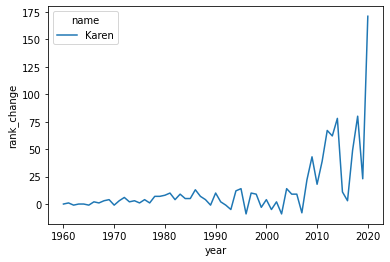

In [179]:
sns.lineplot(x='year', y='rank_change', hue='name', data=df[df.name == 'Karen'])

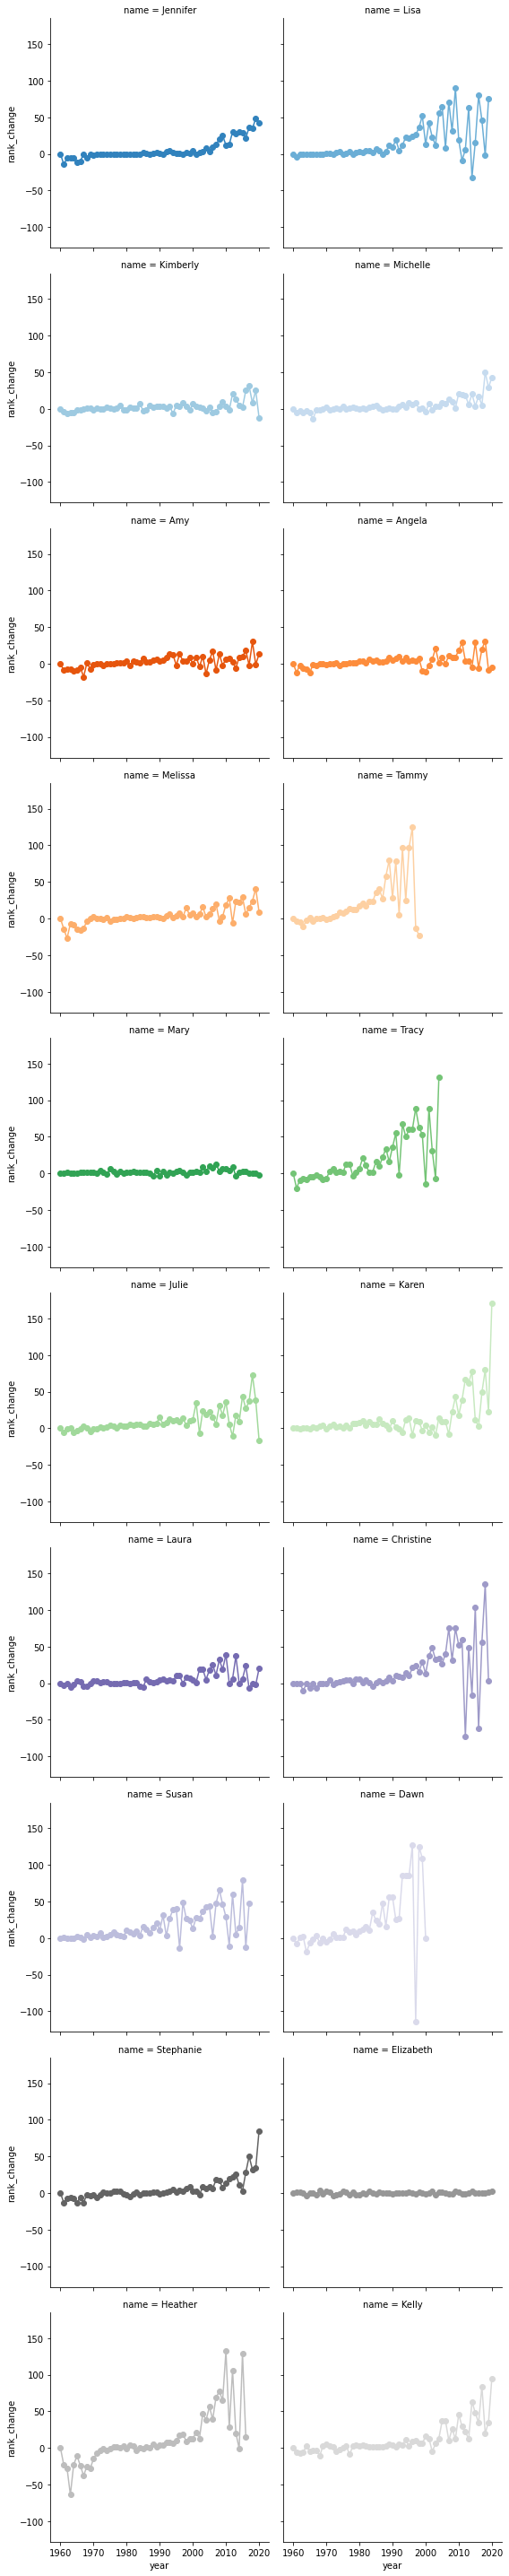

In [180]:
from matplotlib import pyplot as plt

grid = sns.FacetGrid(df, col="name", hue="name", palette="tab20c", col_wrap=2, height=4)
grid.map(plt.plot, "year", "rank_change", marker="o")

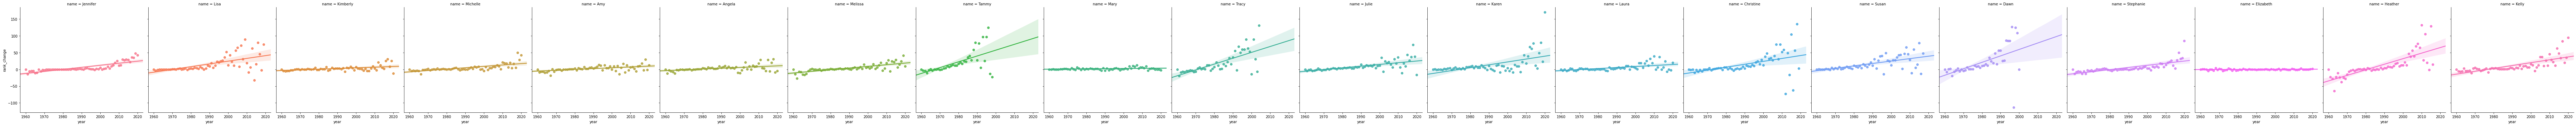

In [181]:
g = sns.lmplot(x="year", y="rank_change", col="name", hue="name", data=df,
               y_jitter=.02, truncate=False)

In [185]:
# lets create a new dataframe just tracking the single largest rank change between years for each name
rank_change_df = pd.DataFrame([])
rank_change_df['name'] = pd.unique(df.name)
rank_change_df = rank_change_df.join(df.groupby(by='name').agg({'rank_change': 'max'})['rank_change'], on='name', rsuffix='_max')
rank_change_df = rank_change_df.join(df.groupby(by='name').agg({'rank_change': 'mean'})['rank_change'], on='name', rsuffix='_avg')
rank_change_df['rank_change_max_avg_diff'] = rank_change_df['rank_change'] - rank_change_df['rank_change_avg']
rank_change_df = rank_change_df.sort_values(by='rank_change_max_avg_diff', ascending=False)
rank_change_df

,name,rank_change,rank_change_avg,rank_change_max_avg_diff
11,Karen,171.0,13.557377,157.442623
13,Christine,135.0,14.733333,120.266667
18,Heather,132.0,11.947368,120.052632
9,Tracy,131.0,19.266667,111.733333
15,Dawn,127.0,20.926829,106.073171
7,Tammy,125.0,20.769231,104.230769
19,Kelly,95.0,11.426230,83.573770
16,Stephanie,85.0,5.672131,79.327869
1,Lisa,90.0,15.816667,74.183333
10,Julie,73.0,9.606557,63.393443


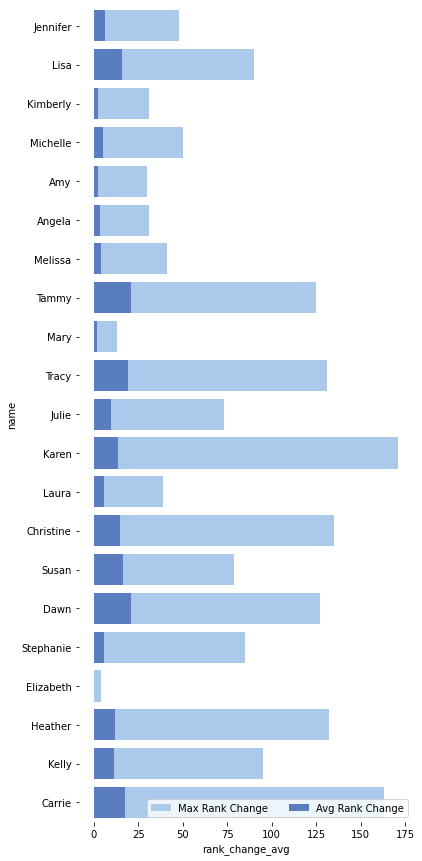

In [163]:
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
sns.barplot(x="rank_change", y="name", data=rank_change_df,
            label="Max Rank Change", color="b")

sns.set_color_codes("muted")
sns.barplot(x="rank_change_avg", y="name", data=rank_change_df,
            label="Avg Rank Change", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)